This will use the ESA SNAP GPT tool to create GRD products from the already downloaded SLC imagery. With the GRD data, the Normalized Difference Polarization Index, VV/VH, VH/VV, Normalized VH index, and Normalized VV index will be used to create water masks. Otsu thresholding will be done to label pixels as subaqeuous or subaerial.

These labeled pixels will be used for two things:
1. Generating a water mask for the InSAR time series (maybe the lowest water extent)
2. Generating a time series of subaerial change for individual creation sites

Plan is to couple the InSAR and Area time series to estimate volumetric changes of wetland BUDM sites 

In [11]:
import os
import subprocess
from datetime import datetime
import shutil
from osgeo import gdal
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Functions

In [12]:
def gpt_help():

    cmd = f'{GPT_PATH} -h -c {MEMORY_SIZE}'

    try:
        result = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

def help_cmd(cmdname):

    cmd = f'{GPT_PATH} {cmdname} -h -c {MEMORY_SIZE}'

    try:
        result = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

def project_dir(slcpath):
    """
    This function reads in a string that you wish to make your working directory 
    for the InSAR project, and creates a data directory to store the data for ISCE2 and mintpy
    work-dir = str
        path to the directory created in 01_get_slc.ipynb
    """
    
    grd_dir=slcpath.replace('SLC','GRD')
    os.makedirs(grd_dir, exist_ok=True)

    # list of grd directories
    grdpaths = []
    for step in ['01_orbit', '02_tnr', '03_cal', '04_deburst', '05_multilook', '06_subset', '07_speckle', '08_tf', '09_tc', '10_netcdfs', '11_composites']:
        grdpaths.append(os.path.join(grd_dir, step))
        os.makedirs(os.path.join(grd_dir, step), exist_ok=True, mode=0o777)

    return grd_dir, grdpaths

def visualize_nc_file(nc_file):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Extract variables
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    gamma0_vv = dataset.variables['Gamma0_VV'][:]
    gamma0_vh = dataset.variables['Gamma0_VH'][:]

    # Close the dataset after reading
    dataset.close()

    # Determine global min/max for consistent color scaling
    vmin = min(gamma0_vv.min(), gamma0_vh.min())
    vmax = max(gamma0_vv.max(), gamma0_vh.max())

    # Plot Gamma0_VV
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    im1 = plt.imshow(gamma0_vv, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(im1, label='Gamma0_VV')
    plt.title('Gamma0_VV')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Plot Gamma0_VH
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(gamma0_vh, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, label='Gamma0_VH')
    plt.title('Gamma0_VH')
    plt.xlabel('Longitude')

    plt.tight_layout()
    plt.show()

def check_spatial_resolution(nc_file):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Extract latitude and longitude
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]

    # Close the dataset
    dataset.close()

    # Calculate the resolution by taking the mean difference
    lat_res = np.abs(lat[1] - lat[0])  # Latitude resolution
    lon_res = np.abs(lon[1] - lon[0])  # Longitude resolution

    print(f"Latitude resolution: {lat_res:.6f} degrees")
    print(f"Longitude resolution: {lon_res:.6f} degrees")

    # Approximate resolution in meters (assuming 1 degree ≈ 111 km)
    lat_res_m = lat_res * 111000
    lon_res_m = lon_res * 111000 * np.cos(np.deg2rad(lat.mean()))

    print(f"Approximate pixel size: {lat_res_m:.2f} meters (latitude), {lon_res_m:.2f} meters (longitude)")

def compute_and_save_indices(input_nc, output_nc):
    # Step 1: Read data from the original NetCDF file (read-only mode)
    dataset = nc.Dataset(input_nc, mode='r')

    # Extract the Gamma0 backscatter values
    vv = dataset.variables['Gamma0_VV'][:].astype(np.float32)
    vh = dataset.variables['Gamma0_VH'][:].astype(np.float32)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]

    # Close the input dataset after reading
    dataset.close()

    # Step 2: Compute SAR indices

    # Avoid division by zero by replacing zeros with a small value
    vv_safe = np.where(vv == 0, np.nan, vv)
    vh_safe = np.where(vh == 0, np.nan, vh)

    vh_vv = vh_safe / (vv_safe + 1e-8)    # VH/VV Ratio (VH_VV)

    ndpi = (vv_safe - vh_safe) / (vv_safe + vh_safe + 1e-8)    # Normalized Difference Polarization Index (NDPI)

    nvhi = vh_safe / (vh_safe + vv_safe + 1e-8)    # Normalized VH Index (NVHI)

    nvvi = vv_safe / (vv_safe + vh_safe + 1e-8)    # Normalized VV Index (NVVI)

    rvi = (4 * vh_safe) / (vh_safe + vv_safe + 1e-8)    # Radar Vegetation Index (RVI)

    # Step 3: Write the computed indices to a new NetCDF file
    new_dataset = nc.Dataset(output_nc, mode='w', format='NETCDF4')

    # Define dimensions
    new_dataset.createDimension('lat', lat.shape[0])
    new_dataset.createDimension('lon', lon.shape[0])

    # Copy latitude and longitude variables to the new dataset
    lat_var = new_dataset.createVariable('lat', np.float64, ('lat',))
    lon_var = new_dataset.createVariable('lon', np.float64, ('lon',))
    lat_var[:] = lat
    lon_var[:] = lon

    # Create and write the computed indices (without original bands)
    indices = {
        "VH_VV": vh_vv,
        "NDPI": ndpi,
        "NVHI": nvhi,
        "NVVI": nvvi,
        "RVI": rvi
    }

    for index_name, index_data in indices.items():
        var = new_dataset.createVariable(index_name, np.float32, ('lat', 'lon'), fill_value=np.nan)
        var[:] = index_data
        var.units = "unitless"
        var.description = f"{index_name} computed SAR index"

    # Add metadata
    new_dataset.title = "Sentinel-1 SAR Indices Dataset"
    new_dataset.description = "Contains computed SAR indices only."
    new_dataset.source = "Computed from Sentinel-1 SLC product"

    # Close the output dataset
    new_dataset.close()

    print(f"New NetCDF file saved as {output_nc}")

def visualize_nc_band(nc_file, band_name):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Check if the band exists
    if band_name not in dataset.variables:
        print(f"Error: Band '{band_name}' not found in the NetCDF file.")
        print("Available bands:", list(dataset.variables.keys()))
        dataset.close()
        return

    # Extract latitude, longitude, and the requested band
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    band_data = dataset.variables[band_name][:]

    # Close the dataset after reading
    dataset.close()

    # Handle missing values (replace with NaN)
    band_data = np.where(np.isnan(band_data), np.nanmin(band_data), band_data)

    # Clip values to avoid extreme outliers
    vmin, vmax = np.percentile(band_data, [1, 99])

    # Plot the specified band with enhanced visualization
    plt.figure(figsize=(8, 6))
    plt.imshow(band_data, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label=band_name)
    plt.title(f'{band_name} Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # plt.grid(True)
    plt.show()

# Establish GPT path, number of processors, and memory usage

In [13]:
GPT_PATH = '/home/clay/esa-snap/bin/gpt'
NUM_PROCESSORS = 24
MEMORY_SIZE = '96G'

# Get GRD images that were downloaded

In [14]:
# assuming you have downloaded .zip files covering your AOI from ASF Vertex
# enter the file directory below
slc_zips = '/home/clay/Documents/SabineRS/Sentinel-1/SLC/ASCENDING/136/93'

slc_zips_list = sorted(os.listdir(slc_zips), key=lambda x: datetime.strptime(x[17:25], '%Y%m%d'))
slc_zips_dirs = [os.path.join(slc_zips, slc) for slc in slc_zips_list]
slc_zips_dates = [slc[17:25] for slc in slc_zips_list]

# Establish GRD working directories

In [15]:
grd_dir, grdpaths = project_dir(slc_zips)

# Choose which polarizations you want to process

In [16]:
POLARISATIONS = 'VV,VH' #can define this here for the rest of the notebook, if need to change will do 

1. Apply-Orbit-File (this is the longest one, took me like 2 hours for 130+ images with 24 processors and 96G of ram)

In [ ]:
ORBIT_TYPE = 'Sentinel Precise (Auto Download)'     # str, options include'Sentinel Precise (Auto Download)', 'Sentinel Restituted (Auto Download)', 'DORIS Preliminary POR (ENVISAT)', 'DORIS Precise VOR (ENVISAT) (Auto Download)', 'DELFT Precise (ENVISAT, ERS1&2) (Auto Download)', 'PRARE Precise (ERS1&2) (Auto Download)', 'Kompsat5 Precise'
POLY_DEGREE = 3                                     # int
CONTINUE_ON_FAIL = False

orbit_outpaths = []
for i, file in enumerate(slc_zips_list):
    orbit_outpaths.append(os.path.join(grdpaths[0], f'{slc_zips_dates[i]}.dim'))
    orbit_cmd = f'{GPT_PATH} Apply-Orbit-File -Ssource={os.path.join(slc_zips,file)} -PcontinueOnFail={CONTINUE_ON_FAIL} -PorbitType="{ORBIT_TYPE}" -PpolyDegree={POLY_DEGREE} -t {orbit_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(orbit_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

2. ThermalNoiseRemoval

In [ ]:
OUTPUT_NOISE = False
REINTRODUCE_TN = False
REMOVE_TN = True

tnr_outpaths = []
for i, file in enumerate(slc_zips_list):
    tnr_outpaths.append(os.path.join(grdpaths[1], f'{slc_zips_dates[i]}.dim'))
    tnr_cmd = f'{GPT_PATH} ThermalNoiseRemoval -SsourceProduct={orbit_outpaths[i]} -PoutputNoise={OUTPUT_NOISE} -PreIntroduceThermalNoise={REINTRODUCE_TN} -PremoveThermalNoise={REMOVE_TN} -PselectedPolarisations={POLARISATIONS} -t {tnr_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(tnr_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(orbit_outpaths[i]) # removes the just used source product
    shutil.rmtree(orbit_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[0])  # removes the previous step folder

3. Calibration

In [ ]:
BETA_BAND = True
OUT_BETA = True
GAMMA_BAND = False
OUT_GAMMA = False
COMPLEX_IM = False
DB_IM = False
SIGMA_BAND = True

cal_outpaths = []
for i, file in enumerate(slc_zips_list):
    cal_outpaths.append(os.path.join(grdpaths[2], f'{slc_zips_dates[i]}.dim'))

    cal_cmd = f'{GPT_PATH} Calibration -Ssource={tnr_outpaths[i]} -PcreateBetaBand={BETA_BAND} -PcreateGammaBand={GAMMA_BAND} -PoutputBetaBand={OUT_BETA} -PoutputGammaBand={OUT_GAMMA} -PoutputImageInComplex={COMPLEX_IM} -PoutputImageScaleInDb={DB_IM} -PoutputSigmaBand={SIGMA_BAND} -PselectedPolarisations={POLARISATIONS} -t {cal_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(cal_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(tnr_outpaths[i]) # removes the just used source product
    shutil.rmtree(tnr_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[1])

4. TOPSAR-Deburst

In [ ]:
deburst_outpaths = []
for i, file in enumerate(slc_zips_list):
    deburst_outpaths.append(os.path.join(grdpaths[3], f'{slc_zips_dates[i]}.dim'))

    deburst_cmd = f'{GPT_PATH} TOPSAR-Deburst -Ssource={cal_outpaths[i]} -PselectedPolarisations={POLARISATIONS} -t {deburst_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(deburst_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(cal_outpaths[i]) # removes the .dim just used source product
    shutil.rmtree(cal_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[2])

5. Multilook

In [ ]:
SQUARE_PIXEL = False
AZI_LOOKS = '1'         # sentinel-1 is 22m in azimuth
RANGE_LOOKS = '5'       # sentinel-1 is between 2.7 and 3.5m in range, depending on topography

mlook_outpaths = []
for i, file in enumerate(slc_zips_list):
    mlook_outpaths.append(os.path.join(grdpaths[4], f'{slc_zips_dates[i]}.dim'))

    mlook_cmd = f'{GPT_PATH} Multilook -Ssource={deburst_outpaths[i]} -PgrSquarePixel={SQUARE_PIXEL} -PnAzLooks={AZI_LOOKS} -PnRgLooks={RANGE_LOOKS} -t {mlook_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(mlook_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(deburst_outpaths[i]) # removes the just used source product
    shutil.rmtree(deburst_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[3])

6. Subset? (using the aoi from the initial wrapped ifg)

In [ ]:
# first, get the wrapped ifg from 02a_isce2_processing.ipynb

ds = gdal.Open('/home/clay/Documents/SabineRS/Sentinel-1/InSAR/interferometry/work/merged/filt_topophase.flat.geo.vrt', gdal.GA_ReadOnly)
slc = ds.GetRasterBand(1).ReadAsArray()
transform = ds.GetGeoTransform()
ds = None

# getting the min max of the axes
firstx = transform[0]
firsty = transform[3]
deltay = transform[5]
deltax = transform[1]
lastx = firstx+slc.shape[1]*deltax
lasty = firsty+slc.shape[0]*deltay
ymin = np.min([lasty,firsty])
ymax = np.max([lasty,firsty])
xmin = np.min([lastx,firstx])
xmax = np.max([lastx,firstx])

aoi = f'POLYGON(({round(xmax,2)} {round(ymin,2)}, {round(xmax,2)} {round(ymax,2)}, {round(xmin,2)} {round(ymax,2)}, {round(xmin,2)} {round(ymin,2)}, {round(xmax,2)} {round(ymin,2)}))'
print(aoi)

In [ ]:
COPY_METADATA = True
FULL_SWATH = False
REFERNCE_BAND = 'Beta0_VV'

subset_outpaths = []
for i, file in enumerate(slc_zips_list):
    subset_outpaths.append(os.path.join(grdpaths[5], f'{slc_zips_dates[i]}.dim'))

    subset_cmd = f'{GPT_PATH} Subset -Ssource={mlook_outpaths[i]} -PcopyMetadata={COPY_METADATA} -PfullSwath={FULL_SWATH} -PgeoRegion="{aoi}" -PreferenceBand={REFERNCE_BAND} -t {subset_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(subset_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(mlook_outpaths[i]) # removes the just used source product
    shutil.rmtree(mlook_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[4])

7. Speckle-Filter

In [ ]:
NEIGHBORHOOD_SIZE = 100 # integer, (1, 200]
DAMPING_FACTOR = 2      # integer, for the Frost filter only
NUM_LOOKS = 1.0         # integer, (0, *)
ESTIMATE_ENL = False
FILTER = 'Lee Sigma'  # str, otptions include None, Boxcar, Median, Frost, Gamma Map, Lee, Refined Lee, Lee Sigma, or IDAN
FILTER_XSIZE = 3        # integer, (1, 100]
FITLER_YSIZE = 3        # integer, (1, 100]
NUM_LOOKS_STR = '1'         # str of integer, options are '1', '2', '3', '4'
SIGMA_STR = '0.9'       # str, options are '0.5', '0.6', '0.7', '0.8', '0.9'
TARGET_WINDOW = '3x3'   # str, can be '3x3' or '5x5'
WINDOW_SIZE = '5x5'     # str, can be '5x5', '7x7', '9x9', '11x11', '13x13', or '15x15'  


filter_outpaths = []
for i, file in enumerate(slc_zips_list):
    filter_outpaths.append(os.path.join(grdpaths[6], f'{slc_zips_dates[i]}.dim'))

    filter_cmd = f'{GPT_PATH} Speckle-Filter -Ssource={subset_outpaths[i]} -PanSize={NEIGHBORHOOD_SIZE} -PdampingFactor={DAMPING_FACTOR} -Penl={NUM_LOOKS} -PestimateENL={ESTIMATE_ENL} -Pfilter="{FILTER}" -PfilterSizeX={FILTER_XSIZE} -PfilterSizeY={FITLER_YSIZE} -PnumLooksStr={NUM_LOOKS_STR} -PsigmaStr={SIGMA_STR} -PtargetWindowSizeStr={TARGET_WINDOW} -PwindowSize={WINDOW_SIZE} -t {filter_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(filter_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(subset_outpaths[i]) # removes the just used source product
    shutil.rmtree(subset_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[5])

8. Terrain-Flattening

In [ ]:
ADDITIONAL_OVERLAP = 0.2                            # double, [0,1]
DEM_NAME = 'Copernicus 30m Global DEM'
DEM_RESAMPLE_METHOD = 'BICUBIC_INTERPOLATION'      # str, options include 'NEAREST_NEIGHBOUR', 'BILINEAR_INTERPOLATION', 'CUBIC_CONVOLUTION', 'BISINC_5_POINT_INTERPOLATION', 'BISINC_11_POINT_INTERPOLATION', 'BISINC_21_POINT_INTERPOLATION', 'BICUBIC_INTERPOLATION'
OVERSAMPLE_MULTIPLE = 2.0                           # double, [1.0, 4.0]
SOURCE_BANDS = 'Beta0_VV,Beta0_VH'

tf_outpaths = []
for i, file in enumerate(slc_zips_list):
    tf_outpaths.append(os.path.join(grdpaths[7], f'{slc_zips_dates[i]}.dim'))

    tf_cmd = f'{GPT_PATH} Terrain-Flattening -Ssource={filter_outpaths[i]} -PadditionalOverlap={ADDITIONAL_OVERLAP} -PdemName="{DEM_NAME}" -PdemResamplingMethod={DEM_RESAMPLE_METHOD} -PoversamplingMultiple={OVERSAMPLE_MULTIPLE} -PsourceBands={SOURCE_BANDS} -t {tf_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(tf_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

    os.remove(filter_outpaths[i]) # removes the just used source product
    shutil.rmtree(filter_outpaths[i][:-4]+'.data')

shutil.rmtree(grdpaths[6])

9. Terrain Correction

In [ ]:
ALIGN_STANDARD_GRID = False
RADIOMETRIC_NORMALIZATION = True
AUX_FILE = 'Product Auxiliary File'   # str, options include 'Latest Auxiliary File', 'Product Auxiliary File', 'External Auxiliary File'
DEM_NAME = 'Copernicus 30m Global DEM'
DEM_RESAMPLE_METHOD = 'DELAUNAY_INTERPOLATION'   # str, options include 'NEAREST_NEIGHBOUR', 'BILINEAR_INTERPOLATION', 'CUBIC_CONVOLUTION', 'BISINC_5_POINT_INTERPOLATION', 'BISINC_11_POINT_INTERPOLATION', 'BISINC_21_POINT_INTERPOLATION', 'BICUBIC_INTERPOLATION', 'DELAUNAY_INTERPOLATION'
IMG_RESAMPLE_METHOD = 'CUBIC_CONVOLUTION' # str, options include 'NEAREST_NEIGHBOUR', 'BILINEAR_INTERPOLATION', 'CUBIC_CONVOLUTION', 'BISINC_5_POINT_INTERPOLATION', 'BISINC_11_POINT_INTERPOLATION', 'BISINC_21_POINT_INTERPOLATION', 'BICUBIC_INTERPOLATION'
NODATA_SEA = False
OUTPUT_COMPLEX = False
PIXEL_SPACING_METERS = 20.0   # double
SAVE_DEM = False
SAVE_ANGLE_ELLIPSOID = False
SAVE_LAT_LON = False
SAVE_LAYOVER_SHADOW = True
SAVE_LOCAL_ANGLE = False
SAVE_PROJ_LOCAL_ANGLE = True
SAVE_SOURCE_BAND = True
SOURCE_BANDS = 'Gamma0_VV,Gamma0_VH'
GRID_ORIGIN_X = 0   # double
GRID_ORIGIN_Y = 0   # double

# only needed if you you are using external dem
# uncomment these and adjust your gpt command below accordingly
#  EXTERNAL_AUX = 
# EXTERNAL_DEMFILE =
# EXTERNAL_DEMFILE_NODATA =
# ETERNAL_DEM_EGM = False

tc_outpaths = []
for i, file in enumerate(slc_zips_list):
    tc_outpaths.append(os.path.join(grdpaths[8], f'{slc_zips_dates[i]}.dim'))

    tc_cmd = f'{GPT_PATH} Terrain-Correction -Ssource={tf_outpaths[i]} -PalignToStandardGrid={ALIGN_STANDARD_GRID} -PapplyRadiometricNormalization={RADIOMETRIC_NORMALIZATION} -PauxFile="{AUX_FILE}" -PdemName="{DEM_NAME}" -PdemResamplingMethod="{DEM_RESAMPLE_METHOD}" -PimgResamplingMethod="{IMG_RESAMPLE_METHOD}" -PnodataValueAtSea={NODATA_SEA} -PoutputComplex={OUTPUT_COMPLEX} -PpixelSpacingInMeter={PIXEL_SPACING_METERS} -PsaveDEM={SAVE_DEM} -PsaveIncidenceAngleFromEllipsoid={SAVE_ANGLE_ELLIPSOID} -PsaveLatLon={SAVE_LAT_LON} -PsaveLayoverShadowMask={SAVE_LAYOVER_SHADOW} -PsaveLocalIncidenceAngle={SAVE_LOCAL_ANGLE} -PsaveProjectedLocalIncidenceAngle={SAVE_PROJ_LOCAL_ANGLE} -PsaveSelectedSourceBand={SAVE_SOURCE_BAND} -PsourceBands={SOURCE_BANDS} -PstandardGridOriginX={GRID_ORIGIN_X} -PstandardGridOriginY={GRID_ORIGIN_Y} -t {tc_outpaths[i]} -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(tc_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")

#     os.remove(tf_outpaths[i]) # removes the just used source product
#     shutil.rmtree(tf_outpaths[i][:-4]+'.data')

# shutil.rmtree(grdpaths[7])

10. Write
- Writes to netcdf4

In [10]:
# tiff doesn't contain metadata. I am going to try export as a NetCDF file instead of GEotiff-Bigtiff

# should be NetCDF4-CF now
write_xml = '/home/clay/Documents/nc_export.xml'

In [ ]:
OUT_BANDS = 'Gamma0_VV,Gamma0_VH'

nc_outpaths = []
for i, file in enumerate(slc_zips_list):
    nc_outpaths.append(os.path.join(grdpaths[9], f'{slc_zips_dates[i]}'))

    rdtc_cmd = f'{GPT_PATH} {write_xml} -Pinput={tc_outpaths[i]} -Poutput={nc_outpaths[i]} -Ppolarisations="{POLARISATIONS}" -Pbands="{OUT_BANDS}" -c {MEMORY_SIZE} -q {NUM_PROCESSORS}'
    try:
        result = subprocess.run(rdtc_cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
    except subprocess.CalledProcessError as e:
        print(f"Command failed: {e.stderr.decode()}")


11. create the 5 composite bands needed for the Otsu thresholding
- will save the original 2 bands in the '10_netcdfs' folder
- will create new .nc files in '11_composites' folder containing the polarization ratio, NVVI, NVHI, RVI, and SWDI

# EDIT THE BELOW FUNCTION TO CREATE NEW .NC FILES FOR THE COMPOSITE BANDS, WHILE KEEPING THE ORIGINAL .NC FILE

In [17]:
nc_outpaths = sorted([os.path.join(grdpaths[9], f'{slc_zips_dates[i]}.nc') for i, file in enumerate(slc_zips_list)])
composite_outpaths = [os.path.join(grdpaths[10], f'{slc_zips_dates[i]}.nc') for i, file in enumerate(slc_zips_list)]

In [ ]:
# this creates the polarization ratio, RVI, NDPI, NVVI, and NVHI from the Gamma0 products
# should be same resolution as the ifg product
# may need to come back and ensure the equations used are correct

for pair in zip(nc_outpaths,composite_outpaths):
    compute_and_save_indices(pair[0], pair[1])

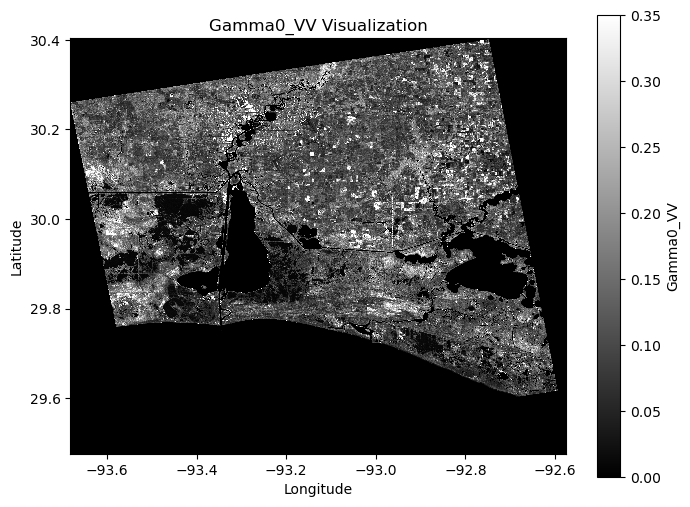

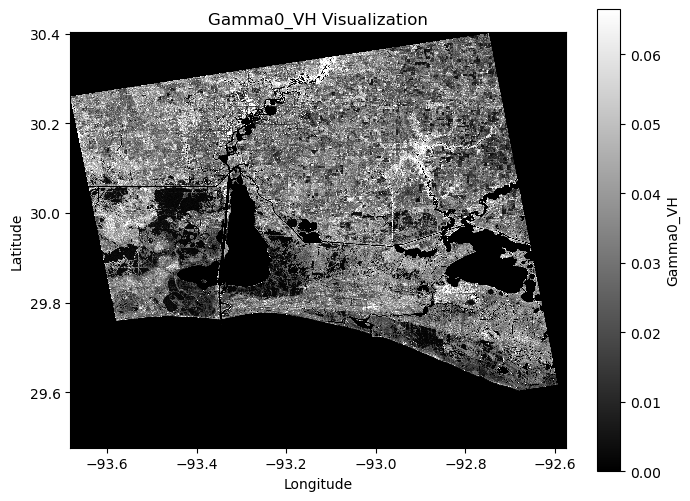

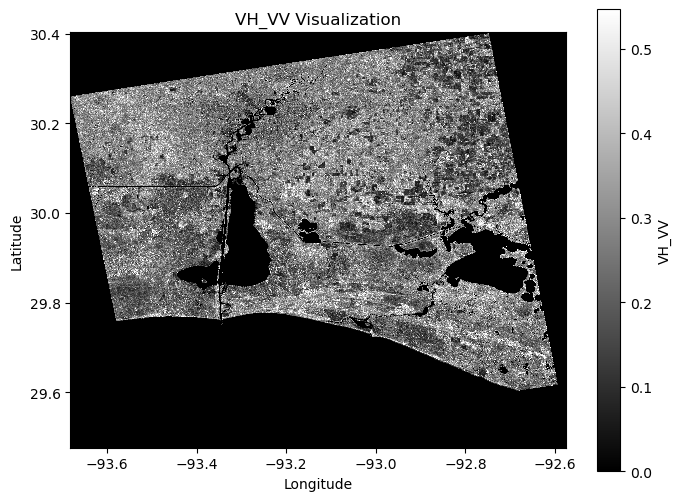

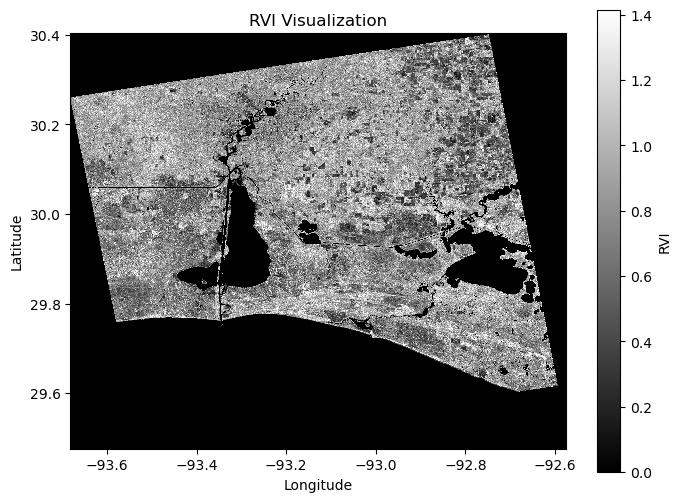

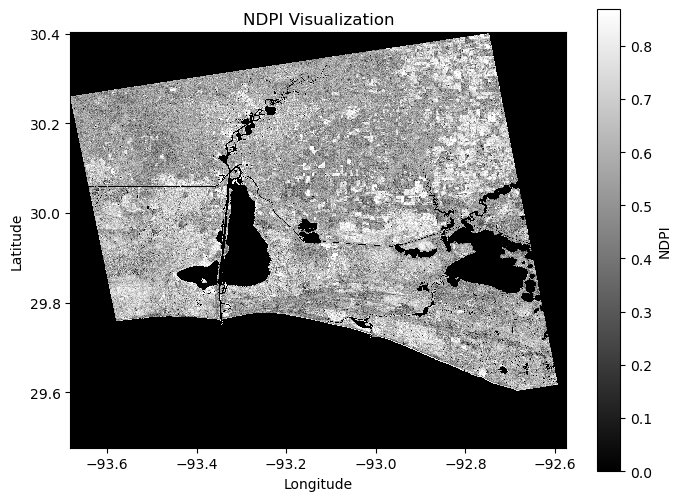

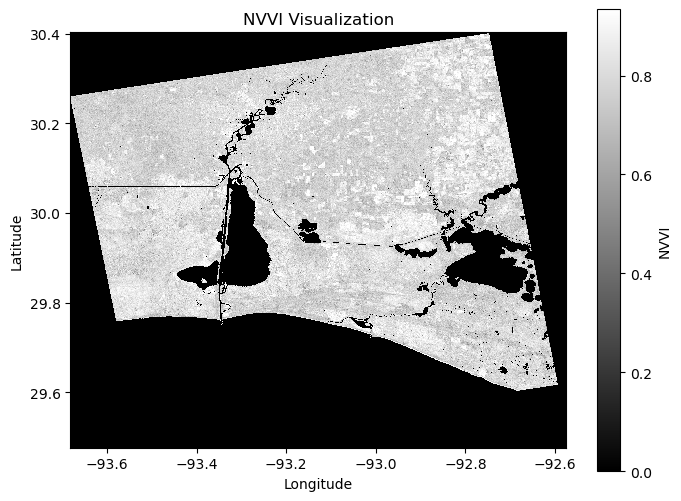

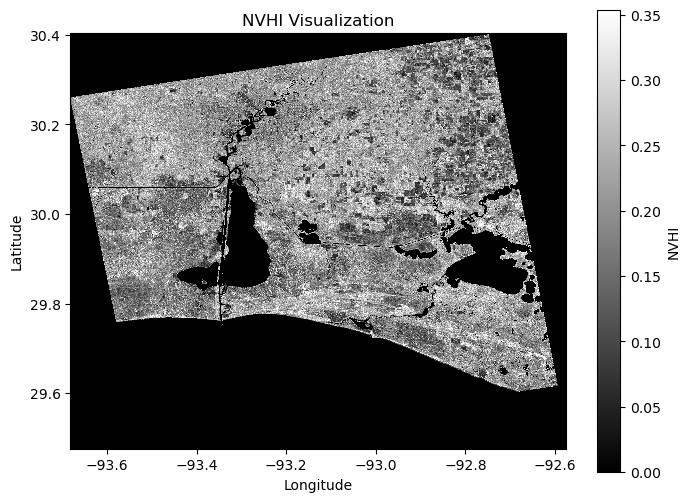

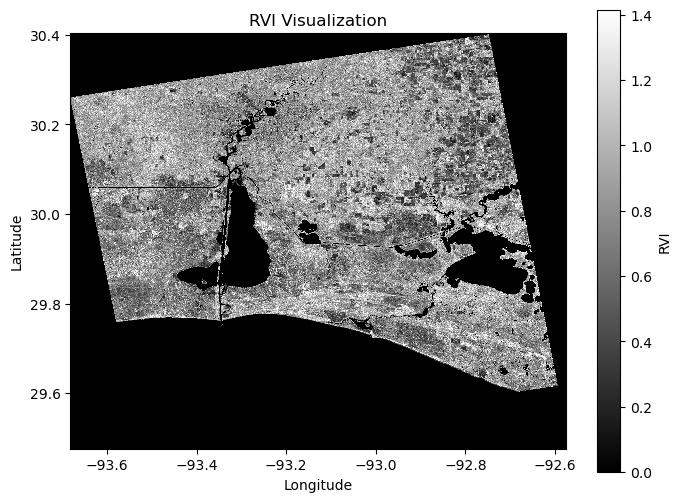

In [18]:
for file, bands in zip([nc_outpaths[0], nc_outpaths[0].replace('10_netcdfs', '11_composites')], [['Gamma0_VV', 'Gamma0_VH'], ['VH_VV', 'RVI', 'NDPI', 'NVVI', 'NVHI', 'RVI']]):
    for band in bands:
        visualize_nc_band(file, band)

# Now that the composite bands are created, can move to 02c_sentinelmask.ipynb. This notebook will use the two .nc files containing the gamma0 backscatters and the composite bands, as well as cloud-masked sentinel-2 imagery retrieved from the GEE, to create Water Masks at the same resolution as the corresponding ifgs.